In [1]:
n_threads = 6

In [2]:
import os
if n_threads is not None:
    os.environ["OMP_NUM_THREADS"] = str(n_threads)

In [4]:
import sys
import yaml
import warnings
warnings.filterwarnings("ignore")

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gpytorch.means import ConstantMean

from xopt import Xopt, VOCS
from xopt.evaluator import Evaluator
from xopt.numerical_optimizer import LBFGSOptimizer
from xopt.generators import UpperConfidenceBoundGenerator, ExpectedImprovementGenerator
from xopt.generators.bayesian.models.standard import StandardModelConstructor
from lume_model.utils import variables_from_yaml
from lume_model.models import TorchModel, TorchModule

## Define VOCS

In [5]:
filename = "../variables.csv"
VARIABLE_RANGES = pd.read_csv(filename, index_col=0, header=None).T.to_dict(orient='list')
VARIABLES = ["SOLN:IN20:121:BCTRL", "QUAD:IN20:121:BCTRL"]
vocs = VOCS(
    variables = {ele: VARIABLE_RANGES[ele] for ele in VARIABLES},
    objectives = {"total_size": "MINIMIZE"},
    constraints = {"c1": ["LESS_THAN", 0.0]},
)
print(vocs.as_yaml())

variables:
  SOLN:IN20:121:BCTRL: [0.377, 0.498]
  QUAD:IN20:121:BCTRL: [-0.021, 0.021]
constraints:
  c1: [LESS_THAN, 0.0]
objectives: {total_size: MINIMIZE}
constants: {}
observables: []



## Define NN prior

In [6]:
objective_scale = 1e-3

In [7]:
model_path = "lcls_cu_injector_nn_model/"

# # load nn_to_cal transformers
# reg = "low"  # "low" or "high"
# input_nn_to_cal = torch.load(f"calibration/input_nn_to_cal_{reg}_reg.pt")
# output_nn_to_cal = torch.load(f"calibration/output_nn_to_cal_{reg}_reg.pt")

# load sim_to_nn transformers
input_sim_to_nn = torch.load(model_path + "model/input_sim_to_nn.pt")
output_sim_to_nn = torch.load(model_path + "model/output_sim_to_nn.pt")

# load pv_to_sim transformers
input_pv_to_sim = torch.load(model_path + "model/input_pv_to_sim.pt")
output_pv_to_sim = torch.load(model_path + "model/output_pv_to_sim.pt")

# load in- and output variable specification
input_variables, output_variables = variables_from_yaml(model_path + "model/pv_variables.yml")
# input_variables, output_variables = variables_from_yaml(f"calibration/pv_variables_{reg}_reg_pydantic2.yml")

# replace keys in input variables
for var in input_variables:
    var.name = var.name.replace("BACT", "BCTRL")

# create TorchModel
lume_model = TorchModel(
    model=model_path + "model/model.pt",
    input_variables=input_variables,
    output_variables=output_variables,
    input_transformers=[input_pv_to_sim, input_sim_to_nn],
    output_transformers=[output_sim_to_nn, output_pv_to_sim],
    # input_transformers=[input_pv_to_sim, input_sim_to_nn, input_nn_to_cal],
    # output_transformers=[output_nn_to_cal, output_sim_to_nn, output_pv_to_sim],
)

# wrap in TorchModule
lume_module = TorchModule(
    model=lume_model,
    input_order=vocs.variable_names,
    output_order=lume_model.output_names[0:2],
)

# define objective model
class ObjectiveModel(torch.nn.Module):
    def __init__(self, model: TorchModule):
        super(ObjectiveModel, self).__init__()
        self.model = model

    @staticmethod
    def function(sigma_x: torch.Tensor, sigma_y: torch.Tensor) -> torch.Tensor:
        # using this calculation due to occasional negative values
        sigma_xy = torch.sqrt(sigma_x ** 2 + sigma_y ** 2)
        roundness = torch.abs(sigma_x - sigma_y)
        return (sigma_xy + roundness) * objective_scale

    def forward(self, x) -> torch.Tensor:
        idx_sigma_x = self.model.output_order.index("OTRS:IN20:571:XRMS")
        idx_sigma_y = self.model.output_order.index("OTRS:IN20:571:YRMS")
        sigma_x = self.model(x)[..., idx_sigma_x]
        sigma_y = self.model(x)[..., idx_sigma_y]
        return self.function(sigma_x, sigma_y)


objective_model = ObjectiveModel(lume_module)

## Define evaluate function

In [8]:
def get_model_predictions(input_dict, generator = None):
    output_dict = {}
    for output_name in generator.vocs.output_names:
        if generator is not None and generator.model is not None:
            gp = generator.model.models[generator.vocs.output_names.index(output_name)]
            gp.eval()
            x = torch.tensor([input_dict[k] for k in generator.vocs.variable_names], dtype=torch.double).unsqueeze(0)
            with torch.no_grad():
                _x = gp.input_transform.transform(x)
                _x = gp.mean_module(_x)
                prior_mean = gp.outcome_transform.untransform(_x)[0].item()
                posterior = gp.posterior(x)
                posterior_mean = posterior.mean.item()
                posterior_sd = torch.sqrt(posterior.mvn.variance).item()
        else:
            prior_mean, posterior_mean, posterior_sd = np.nan, np.nan, np.nan
    
        output_dict[output_name + "_prior_mean"] = prior_mean
        output_dict[output_name + "_posterior_mean"] = posterior_mean
        output_dict[output_name + "_posterior_sd"] = posterior_sd
    return output_dict

In [9]:
# Xopt evaluator function
def evaluate(input_dict, generator = None):
    model_result = lume_model.evaluate(input_dict)
    sigma_xy = objective_model.function(model_result["OTRS:IN20:571:XRMS"], model_result["OTRS:IN20:571:YRMS"])
    output_dict = {vocs.objective_names[0]: sigma_xy.detach().item()}
    
    # dummy constraint
    output_dict["c1"] = output_dict[vocs.objective_names[0]] - 3e3

    # GP model predictions
    model_predictions = get_model_predictions(input_dict, generator)
    output_dict.update(model_predictions)
    
    return output_dict

## Restrict ranges based on profile monitor

In [10]:
vocs.variables = {k: input_variables[lume_model.input_names.index(k)].value_range for k in vocs.variable_names}
vocs.variables["SOLN:IN20:121:BCTRL"] = [0.467, 0.479]
print(vocs.as_yaml())

variables:
  QUAD:IN20:121:BCTRL: [-0.02098429469554406, 0.020999198106589838]
  SOLN:IN20:121:BCTRL: [0.467, 0.479]
constraints:
  c1: [LESS_THAN, 0.0]
objectives: {total_size: MINIMIZE}
constants: {}
observables: []



## Run Xopt

In [11]:
# remember to set use low noise prior to false!!!
gp_constructor = StandardModelConstructor(
    use_low_noise_prior=False,
    mean_modules={"total_size": ConstantMean()},
    trainable_mean_keys=["total_size"],
)
generator = ExpectedImprovementGenerator(
    vocs=vocs,
    gp_constructor=gp_constructor,
)
generator.numerical_optimizer.max_iter = 200
evaluator = Evaluator(function=evaluate, function_kwargs={"generator": None})
X = Xopt(generator=generator, evaluator=evaluator, vocs=vocs)
X.evaluator = Evaluator(function=evaluate, function_kwargs={"generator": X.generator})

Verifying model name='standard' use_low_noise_prior=False covar_modules={} mean_modules={'total_size': ConstantMean()} trainable_mean_keys=['total_size']


In [12]:
X.random_evaluate(3, seed=0)

,QUAD:IN20:121:BCTRL,SOLN:IN20:121:BCTRL,total_size,c1,total_size_prior_mean,total_size_posterior_mean,total_size_posterior_sd,c1_prior_mean,c1_posterior_mean,c1_posterior_sd,xopt_runtime,xopt_error
0,-0.005743,0.478802,0.545812,-2999.454188,NaN,NaN,NaN,NaN,NaN,NaN,0.001952,False
1,0.009673,0.469241,1.154031,-2998.845969,NaN,NaN,NaN,NaN,NaN,NaN,0.000547,False
2,0.019279,0.468047,1.372965,-2998.627035,NaN,NaN,NaN,NaN,NaN,NaN,0.000316,False


In [13]:
%%time
ot_mean, ot_sd, pm_c = [], [], []

for i in range(25):
    X.step()
    
    gp = X.generator.model.models[generator.vocs.output_names.index(X.vocs.objective_names[0])]
    ot_mean.append(gp.outcome_transform.means.item())
    ot_sd.append(gp.outcome_transform.stdvs.item())
    if hasattr(gp.mean_module, "_model"):
        pm_c.append(gp.mean_module._model.constant.item())
    else:
        pm_c.append(gp.mean_module.constant.item())

CPU times: user 14.3 s, sys: 881 ms, total: 15.2 s
Wall time: 14.8 s


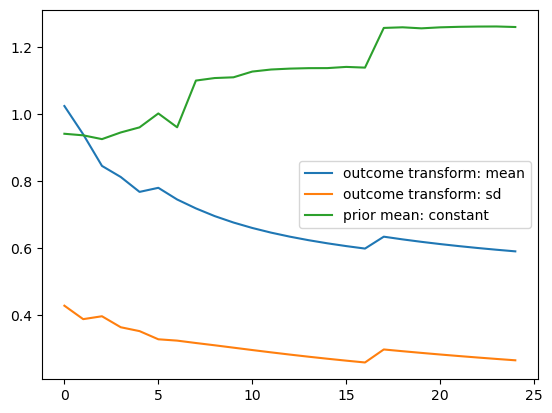

In [14]:
fig, ax = plt.subplots()
ax.plot(ot_mean, label="outcome transform: mean")
ax.plot(ot_sd, label="outcome transform: sd")
ax.plot(pm_c, label="prior mean: constant")
ax.legend();

## Display GP Models

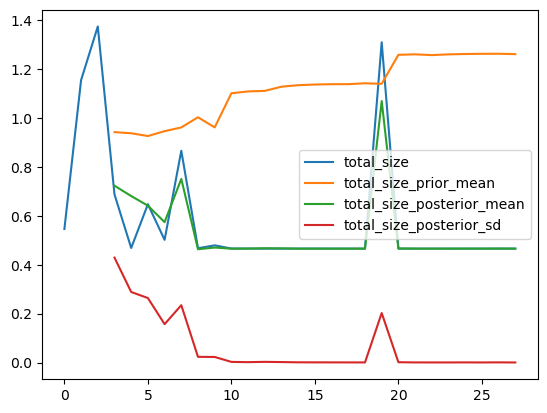

In [15]:
X.data[["total_size" + k for k in ["", "_prior_mean", "_posterior_mean", "_posterior_sd"]]].plot();

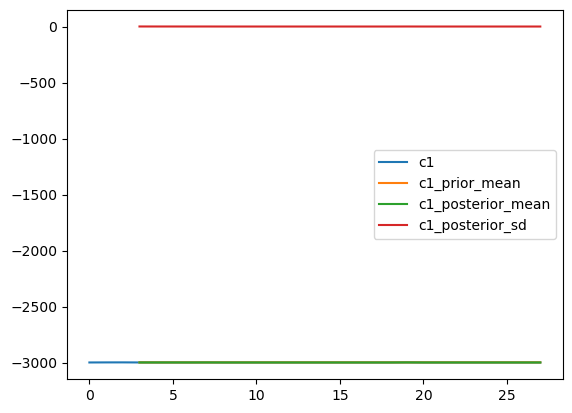

In [16]:
X.data[["c1" + k for k in ["", "_prior_mean", "_posterior_mean", "_posterior_sd"]]].plot();

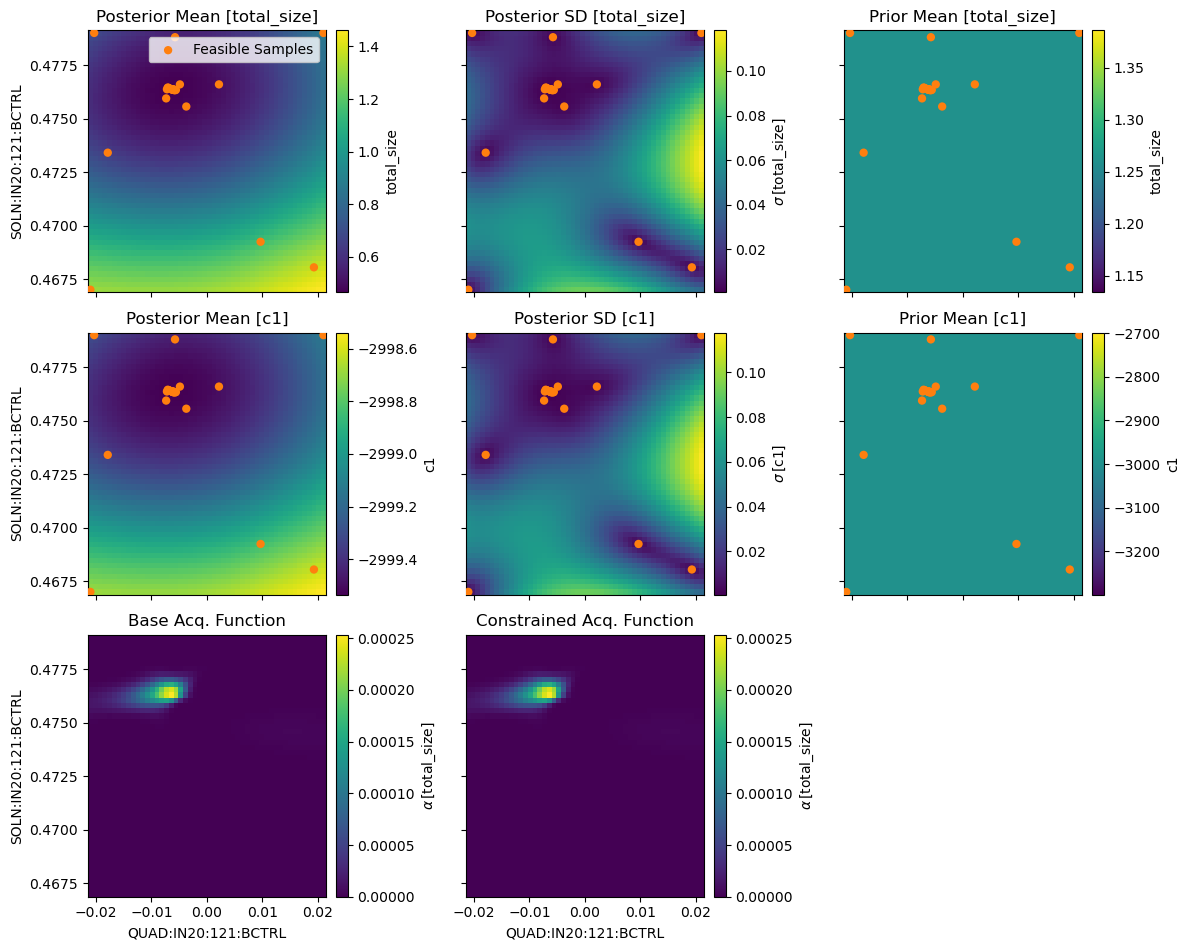

In [17]:
X.generator.visualize_model(show_prior_mean=True);